__3. ALTÉMA: HOLD VS MARS__

*0) Importok és beállítások*

In [2]:

from utils import (
    countries, non_english_countries, iso2_to_iso3,
    get_countries_df, add_iso3,
    fetch_gnews_for_countries,
    score_sentiment_vader, load_xlmr_model, predict_sentiment_batch_xlmr,
    make_country_aggregates, plot_four_maps_for_topic, top_examples_all
)

# VADER lexikon (EN-hez)
import nltk
nltk.download('vader_lexicon', quiet=True)

TOPIC_NAME = "moon_mars"   # vagy: politics_finance
USE_CACHE  = True                # ha van korábbi CSV, onnan olvas


*1) Keresőkifejezés (Hold / Mars altéma)*

In [3]:

TOPIC_NAME = "moon_mars"

base_terms = [
    '"space exploration"', '"space mission"', '"space flight"',
    'NASA','ESA','SpaceX','Blue Origin','ISRO','Roscosmos',
    'satellite','telescope','rocket','lunar','moon','mars','rover'
]
theme_terms = [
    'moon','lunar','Artemis',
    'Mars','rover','lander'
]
topic_base  = " OR ".join(base_terms)
topic_theme = " OR ".join(theme_terms)
topic_query = f"({topic_base}) AND ({topic_theme})"


*2) Angol hírek lekérése + VADER + mentés*

In [4]:
import os, pandas as pd
en_raw  = f"data/raw/{TOPIC_NAME}_en_raw.csv"
en_proc = f"data/processed/{TOPIC_NAME}_en.csv"
os.makedirs("data/raw", exist_ok=True); os.makedirs("data/processed", exist_ok=True)

if USE_CACHE and os.path.exists(en_proc):
    news_en = pd.read_csv(en_proc)
else:
    news_en = fetch_gnews_for_countries(topic_query, countries, limit=120, source_lang="EN")
    news_en.to_csv(en_raw, index=False)  # nyers

    news_en["sentiment"] = news_en["title"].apply(score_sentiment_vader)
    news_en["sentiment_label"] = news_en["sentiment"].apply(
        lambda x: "positive" if x>=0.2 else ("negative" if x<=-0.2 else "neutral")
    )
    news_en = add_iso3(news_en, "iso2")
    news_en.to_csv(en_proc, index=False)  # feldolgozott

*3) Nem angol hírek + XLM-R + mentés*

In [5]:
non_raw  = f"data/raw/{TOPIC_NAME}_non_en_raw.csv"
non_proc = f"data/processed/{TOPIC_NAME}_non_en.csv"

if USE_CACHE and os.path.exists(non_proc):
    news_non = pd.read_csv(non_proc)
else:
    news_non = fetch_gnews_for_countries(topic_query, non_english_countries, limit=120, source_lang="NON_EN")
    news_non.to_csv(non_raw, index=False)

    tok, mdl, device = load_xlmr_model()
    news_non["sentiment_label"] = predict_sentiment_batch_xlmr(news_non["title"].tolist(), tok, mdl, device)
    news_non["sentiment"] = news_non["sentiment_label"].map({"negative":-1.0,"neutral":0.0,"positive":1.0})
    news_non = add_iso3(news_non, "iso2")
    news_non.to_csv(non_proc, index=False)

*4) Összefűzés + skálázás*

In [6]:
all_news = pd.concat([news_en, news_non], ignore_index=True)

# ha kombinált mediánt/átlagot szeretnénk -1/0/+1-en: EN átskálázása
def to_combo(row):
    if row["source_lang"] == "EN":
        x = row["sentiment"]
        return 1.0 if x>=0.2 else (-1.0 if x<=-0.2 else 0.0)
    return row["sentiment"]

all_news["sentiment"] = all_news.apply(to_combo, axis=1)

*5) Kibővített vizualizáció (4 térkép) + CSV-k*

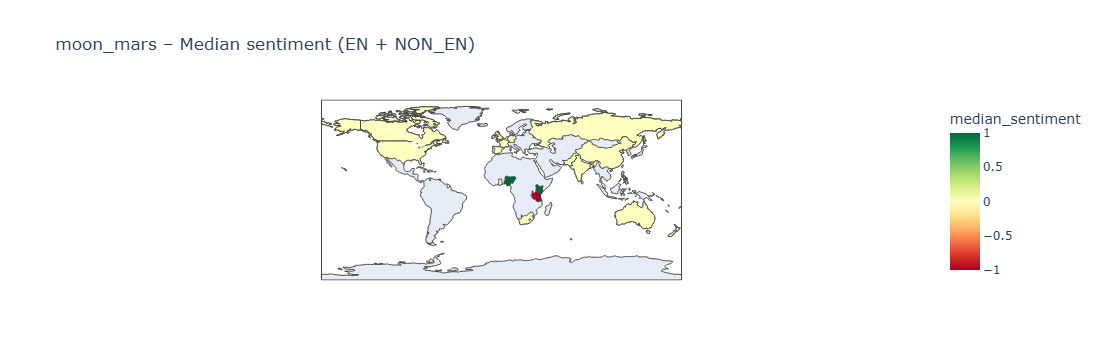

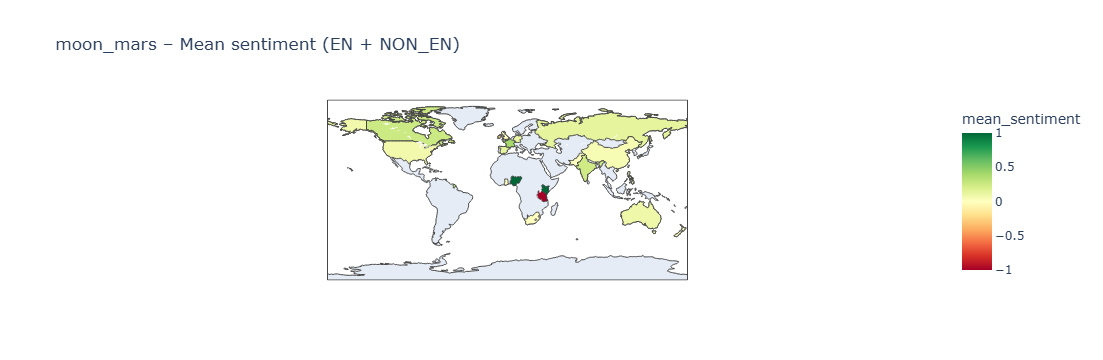

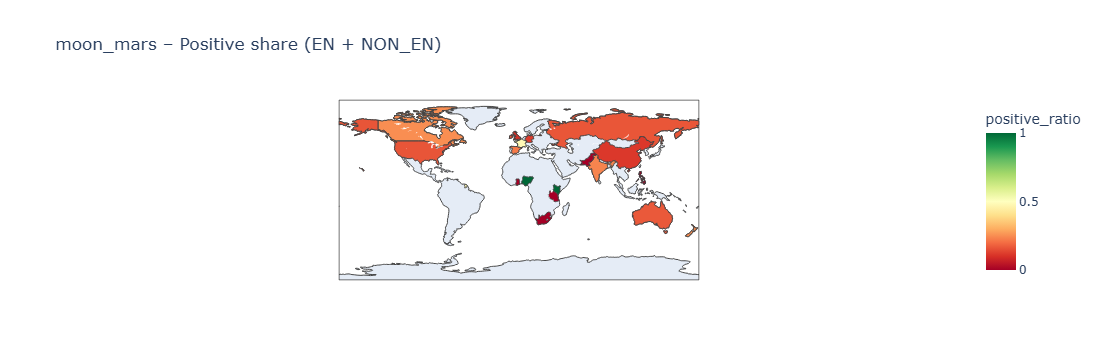

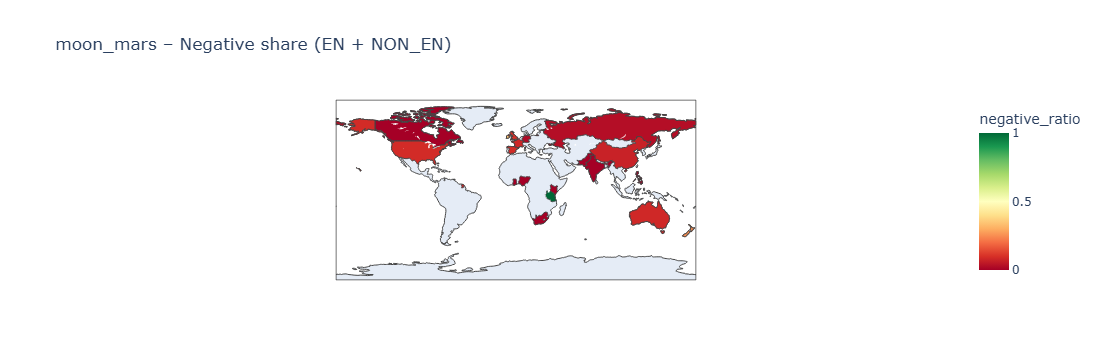

In [7]:
plot_four_maps_for_topic(all_news, topic_name=TOPIC_NAME, use_iso3=True)

*6) Példacímek (Hiszem, ha látom)*

In [8]:
top_pos = top_examples_all(all_news, "positive", 10, per_country=False)
top_neg = top_examples_all(all_news, "negative", 10, per_country=False)
display(top_pos); display(top_neg)

,country,source_lang,title,sentiment,sentiment_label,source,link
0,United States,EN,Rare Black Moon coming August 22-23! Why so sp...,1.0,positive,EarthSky,https://news.google.com/rss/articles/CBMihgFBV...
1,United States,EN,Black moon tonight? Rare August 22 event will ...,1.0,positive,Fast Company,https://news.google.com/rss/articles/CBMizwFBV...
2,United States,EN,NASA Seeks Proposals for 2026 Human Exploratio...,1.0,positive,NASA (.gov),https://news.google.com/rss/articles/CBMiuAFBV...
3,United States,EN,Moon Flybys Could Save Fuel On Interplanetary ...,1.0,positive,Universe Today,https://news.google.com/rss/articles/CBMimAFBV...
4,United States,EN,"After recent tests, China appears likely to be...",1.0,positive,Ars Technica,https://news.google.com/rss/articles/CBMivgFBV...
5,United States,EN,Moon phase today: What the moon will look like...,1.0,positive,Mashable,https://news.google.com/rss/articles/CBMiYkFVX...
6,United States,EN,Black Moon rising: Rare sight graces night sky...,1.0,positive,102.3 KRMG,https://news.google.com/rss/articles/CBMirAFBV...
7,United States,EN,"Don't miss Mercury, the moon and the Beehive C...",1.0,positive,Space,https://news.google.com/rss/articles/CBMigwFBV...
8,United States,EN,NASA seeks student entries for Human Explorati...,1.0,positive,upi.com,https://news.google.com/rss/articles/CBMikAFBV...
9,United States,EN,Moon phase today: What the moon will look like...,1.0,positive,Mashable SEA,https://news.google.com/rss/articles/CBMiogFBV...


,country,source_lang,title,sentiment,sentiment_label,source,link
0,United States,EN,"As the Rare Black Moon Rises This Weekend, Lun...",-1.0,negative,Discover Magazine,https://news.google.com/rss/articles/CBMi3AFBV...
1,United States,EN,CANCELLED: Muncie Three Trails Music Series – ...,-1.0,negative,Ball State University,https://news.google.com/rss/articles/CBMinAFBV...
2,United States,EN,BREAKING: NASA’s Webb Telescope Just Found a N...,-1.0,negative,Orbital Today,https://news.google.com/rss/articles/CBMinAFBV...
3,United States,EN,Getting to the Moon or Mars? Musk and Bezos Ta...,-1.0,negative,The Wall Street Journal,https://news.google.com/rss/articles/CBMikwNBV...
4,United States,EN,Ominous 'black moon' linked to apocalyptic pro...,-1.0,negative,Daily Mail,https://news.google.com/rss/articles/CBMihgFBV...
5,United States,EN,Critics shouldn’t block NASA’s nuclear path to...,-1.0,negative,The Hill,https://news.google.com/rss/articles/CBMihgFBV...
6,United States,EN,NASA Unveils Possible Building Blocks of Life ...,-1.0,negative,SciTechDaily,https://news.google.com/rss/articles/CBMimAFBV...
7,United States,EN,NASA Cameras on Blue Ghost Capture First-of-it...,-1.0,negative,NASA (.gov),https://news.google.com/rss/articles/CBMipgFBV...
8,United States,EN,"Touchdown! Carrying NASA Science, Firefly’s Bl...",-1.0,negative,NASA (.gov),https://news.google.com/rss/articles/CBMiogFBV...
9,United Kingdom,EN,Getting to the Moon or Mars? Musk and Bezos Ta...,-1.0,negative,The Wall Street Journal,https://news.google.com/rss/articles/CBMijgFBV...
